In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.spatial.distance import cdist, euclidean
from sklearn.base import BaseEstimator
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [2]:
def HT(a,k):
    t=np.zeros(a.shape)
    if k==0:
        return t
    else:
        ind=np.argpartition(abs(a),-k, axis=None)[-k:]    
        t[ind]=a[ind]
    return t

class SVAM_ME(BaseEstimator):
# w_star is used only to plot convergence curves and not tune the method or decide stopping criterion in any way
    def __init__( self, alpha=0, beta_init = 0.01 , eta = 1.1, mu_init = None, mu_star = None ):
        self.eta = eta
        self.alpha = alpha
        self.beta_init = beta_init
        self.mu_init = mu_init
        self.mu_star = mu_star

    def fit( self, X, beta_max=1, max_iter = 25):
        n,d = X.shape
        self.mu=self.mu_init
        beta = self.beta_init
        self.l2=[]
        self.clock=[]
        
        start_time=time.time()
        for i in range(max_iter):
            s=np.exp(-beta*np.power(np.linalg.norm(X-self.mu,ord=2,axis=1),2))
            s=s/sum(s)
            self.mu=np.dot(s.reshape((1,n)),X)
            beta=min(beta_max,self.eta*beta)

            self.l2.append(np.linalg.norm(self.mu-mu_star))
            self.clock.append(time.time()-start_time)
        return self

    def predict( self, X ):
        return self.mu
    
    def score( self, X):
        n_test = X.shape[0]
        n_test_corr = int( self.alpha * n_test )
        dist = np.linalg.norm(X - self.mu, axis=1)
        dist_corr = HT( dist, n_test_corr )
        return -np.linalg.norm( dist - dist_corr, 2) / np.sqrt( n_test - n_test_corr )    

In [3]:
n=1000
d=100
alpha=0.4

mu_star= np.random.normal(0,1, (1, d))
mu_star= np.sqrt(2)*mu_star/np.linalg.norm(mu_star)
mu_star=np.zeros((1,d))

mu_adv= np.random.normal(0,1, (1, d))
mu_adv= np.sqrt(6)*mu_adv/np.linalg.norm(mu_adv)

print('Differecen in means: ',np.linalg.norm(mu_star-mu_adv))
n_corr  = int(alpha*n)

Idx= np.random.permutation(n)
corrIdx= np.sort(Idx[0:n_corr])
cleanIdx=np.sort(Idx[n_corr:n])

X = np.random.normal(0,1,(n,d))/np.sqrt(d)
X[cleanIdx,:]= X[cleanIdx,:]+mu_star
X[corrIdx,:]= X[corrIdx,:]+mu_adv


Differecen in means:  2.449489742783178


In [4]:
mu_init=mu_adv

max_iter=25
n_exp=1
n_algo=4

betas=[0.1,0.5,0.9]
beta_max=1

l2_vam=np.zeros(shape=(len(betas),max_iter))
clock_vam=np.zeros(shape=(len(betas),max_iter))

#-------------VAM-RM----------------#

step_beta=1    

vam=SVAM_ME( eta = 1, alpha = alpha, beta_init = betas[0], mu_init = mu_adv, mu_star = mu_star )
vam.fit( X, max_iter=25)
l2_vam[0,:] = vam.l2
clock_vam[0,:] = vam.clock

vam=SVAM_ME( eta = 1, alpha = alpha, beta_init = betas[1], mu_init = mu_adv, mu_star = mu_star )
vam.fit( X, max_iter=25)
l2_vam[1,:] = vam.l2
clock_vam[1,:] = vam.clock

vam=SVAM_ME( eta = 1, alpha = alpha, beta_init = betas[2], mu_init = mu_adv, mu_star = mu_star )
vam.fit( X, max_iter=25)
l2_vam[2,:] = vam.l2
clock_vam[2,:] = vam.clock


print(f'VAM: {betas[0]}, l2={l2_vam[0,-1]:.4f}, time={clock_vam[0,-1]:.4f}')
print(f'VAM: {betas[1]}, l2={l2_vam[1,-1]:.4f}, time={clock_vam[1,-1]:.4f}')
print(f'VAM: {betas[2]}, l2={l2_vam[2,-1]:.4f}, time={clock_vam[2,-1]:.4f}')



#------------Simple Mean Estimation-------------#
start=time.time()
l2_sm=np.linalg.norm(np.mean(X,axis=0)-mu_star)
clock_sm=time.time()-start
print('mean: ', l2_sm)

#---------------Oracle-------------#
start=time.time()
l2_oracle=np.linalg.norm(np.mean(X[cleanIdx,:],axis=0)-mu_star)
clock_oracle=time.time()-start
print('clean mean: ', l2_oracle)

#---------------Co-ordinate-wise Median-------------#
start=time.time()
l2_cm=np.linalg.norm(np.median(X,axis=0)-mu_star)
clock_cm=time.time()-start
print('Co-ordinatewise median: ', l2_cm)

VAM: 0.1, l2=0.8867, time=0.0187
VAM: 0.5, l2=1.9693, time=0.0101
VAM: 0.9, l2=2.4336, time=0.0095
mean:  0.9825046522304538
clean mean:  0.040973600335319695
Co-ordinatewise median:  0.6792921310882948


In [5]:
#------------SVAM-ME-------------#
cross_validation=True

if cross_validation:
    eta_range = np.linspace( 1.01, 20, 21 )
    beta_init_range = np.power( 10.0, [-2, -1, 0, 1, 2] )
    alpha_range = np.linspace( alpha, alpha, 1 )
    # SVAM does not itself use alpha as a hyperparameter in the algorithm
    # but does need it to perform cross-validation since the validation sets
    # are also corrupted. 
    param_grid = dict( eta = eta_range, beta_init = beta_init_range, alpha = alpha_range )
    cv = ShuffleSplit( n_splits = 1, test_size = 0.3, random_state = 42 )
    grid = GridSearchCV( SVAM_ME( mu_init =mu_adv, mu_star = mu_star ), param_grid=param_grid, cv = cv, refit = False )
    grid.fit( X)
    best = grid.best_params_
    print("The best parameters for SVAM are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    svam = SVAM_ME( eta = best["eta"], alpha = best["alpha"], beta_init = best['beta_init'], mu_init = mu_adv, mu_star = mu_star )
else:
    svam = SVAM_ME( eta = 10, alpha = alpha, beta_init = 0.01, mu_init = mu_adv, mu_star = mu_star )

svam.fit( X, max_iter=25)
l2_svam = svam.l2
clock_svam = svam.clock

print(f'SVAM l2={l2_svam[-1]:.4f}, time ={clock_svam[-1]:.4f}')

The best parameters for SVAM are {'alpha': np.float64(0.4), 'beta_init': np.float64(0.01), 'eta': np.float64(1.9594999999999998)} with a score of -1.14
SVAM l2=0.0409, time =0.0112


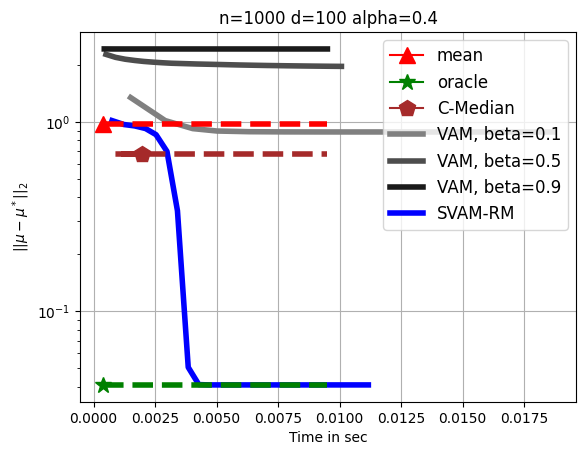

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

file_name='robust_mean'

plt.plot(clock_sm,l2_sm,marker='^',color='red',markersize='12',label = 'mean')
plt.plot(clock_oracle,l2_oracle,marker='*',color='green',markersize='12',label = 'oracle')
plt.plot(clock_cm,l2_cm,marker='p',color='brown',markersize='12',label = 'C-Median')

plt.plot(clock_vam[0,:], l2_vam[0,:], label = 'VAM, beta={}'.format(str(betas[0])),color='0.5',linewidth=4)
plt.plot(clock_vam[1,:], l2_vam[1,:], label = 'VAM, beta={}'.format(str(betas[1])),color='0.3',linewidth=4)
plt.plot(clock_vam[2,:], l2_vam[2,:], label = 'VAM, beta={}'.format(str(betas[2])),color='0.1',linewidth=4)

plt.plot(clock_svam, l2_svam, label = 'SVAM-RM', color='blue',linewidth=4)

clock_vam[2,0]=clock_sm
plt.plot(clock_vam[2,:], np.ones(max_iter)*l2_sm, ls='--', color='red',linewidth=4)
    
clock_vam[2,0]=clock_oracle
plt.plot(clock_vam[2,:], np.ones(max_iter)*l2_oracle, ls='--', color='green',linewidth=4)


clock_vam[2,0]=clock_cm
plt.plot(clock_vam[2,:], np.ones(max_iter)*l2_cm, ls='--', color='brown',linewidth=4)

plt.yscale('log')

plt.legend(prop = {'size': 12},loc='upper right')
plt.xlabel('Time in sec')
plt.ylabel('$||\mu-\mu^*||_2$')
plt.title('n='+str(n)+' d='+str(d)+' alpha='+str(alpha))
plt.grid()
#plt.savefig(file_name+'.pdf')
plt.show()